In [25]:
%matplotlib inline 
import numpy as np
import pylab
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from sklearn.preprocessing import MinMaxScaler
from copy import copy 


In [3]:
#!pip install keras tensorflow

## Read Data

In [5]:
#reference:https://www.data.jma.go.jp/obd/stats/etrn/index.php
weather_data = pd.read_csv('./dataset/weather.csv', header=None, names=["Date", "Rain", "Temp"])
weather_data = weather_data.sort_values(by=['Date'])

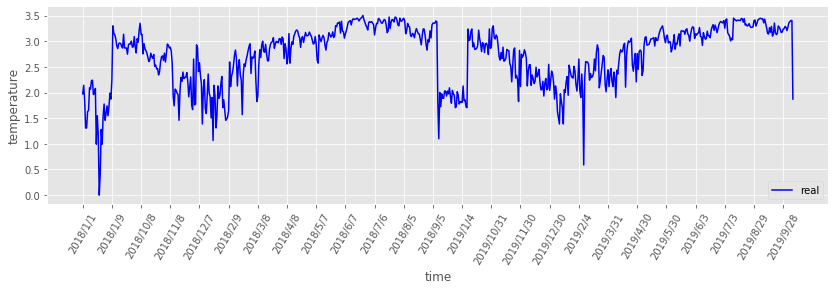

In [8]:
X_orig_tmp = np.nan_to_num(np.log(weather_data["Temp"].values + 1))
X_orig_rain = np.nan_to_num(np.log(weather_data["Rain"].values + 1))
X_day = weather_data["Date"].values

def show_graph(day, data, label, color="b", ylabel='temperature'):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel(ylabel)
    pylab.plot(day, data, color=color, label=label)
    #scale_x_datetime(date_labels = "'%y-%m")
    pylab.legend(loc='lower right')
    pylab.xticks(np.arange(0, len(day), 30), day[::30], rotation=60)
    pylab.show()
    
show_graph(X_day, X_orig_tmp, 'real')

## Hampel filter

In [ ]:
from hampel import Hampel

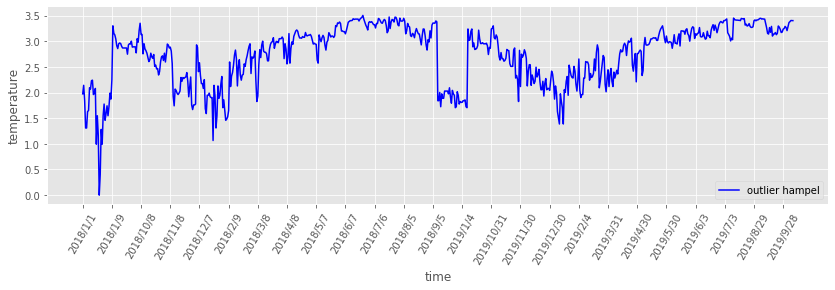

In [10]:
#Hampel
#Outlier
X_hampel = Hampel(X_orig_tmp, k=2, thr=3)
show_graph(X_day, X_hampel[0], 'outlier hampel')


## Exponentially Moving Average

In [11]:
#Exponentially Moving Average
from smoothing import ema

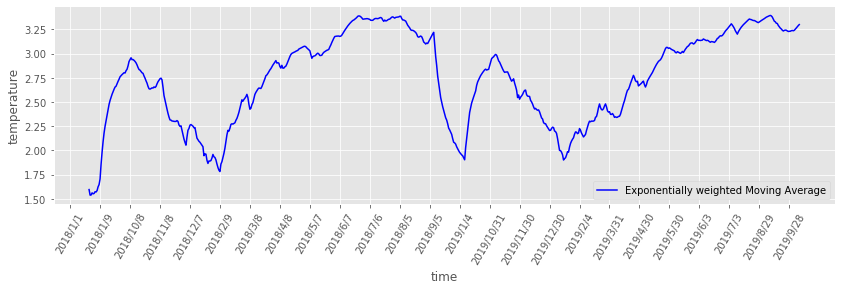

In [12]:
show_graph(X_day, ema(X_hampel[0],20), 'Exponentially weighted Moving Average')

## Dataset

In [16]:
#train test data
X_train = X_orig_tmp[:500]
X_test = X_orig_tmp[500:731]
X_train2 = X_orig_rain[:500]
X_test2 = X_orig_rain[500:731]
X_train_day = X_day[:500]
X_test_day = X_day[500:731]

X_train_joint = np.vstack((X_train, X_train2))
X_test_joint = np.vstack((X_test, X_test2))

In [38]:
import numpy as np
from model import get_data, transform_data, prepare_data, create_model, predict_model_show_graph
 

## Data Normarization

In [40]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    dataX = np.zeros((data.shape[0], data.shape[1], time_steps))
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1] - time_steps - 1):
            dataX[i][j] = data[i, j:(j + time_steps)].T
    return np.array(dataX)

def transform_data(original_data: np.array, 
                   inverse_option: bool, 
                   scaler: object,
                   variable_number: int,
                  ):
    data_shape = original_data.shape
    print(original_data.shape)
    data = original_data.reshape(-1, variable_number)
    print(data.shape)
    if inverse_option is True:
        print('before max {}'.format(max(data[0])))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data[0])))
    else:
        print('before max {}'.format(max(data[0])))
        print('Normalize')
        data = scaler.fit_transform(data)
        print('after max {}'.format(max(data[0])))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps, variable_number):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler, variable_number=variable_number)
    data = np.asarray(data)
    x = get_data(data, time_steps=time_steps)
    x = np.swapaxes(x, 0, 1)
    x = np.swapaxes(x, 1, 2)
    return x, scaler


time_steps = 3
variable_number = 2

x, scaler = prepare_data(X_train_joint, time_steps, variable_number)

input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)
print('input_dim: ', input_dim)
print('timesteps: ', timesteps)

(2, 500)
(500, 2)
before max 2.1400661634962708
Normalize
after max 0.4711798817740287
(2, 500)
(500, 3, 2)
input_dim:  2
timesteps:  3


## Model Create

In [46]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam',
                ):
    with tf.name_scope('Model'):
        x = Input(shape=(time_steps, input_dim,))

        if model_option == 'lstm':
            with tf.name_scope('LSTM'):
                h = LSTM(latent_dim, stateful=False, return_sequences=True)(x)
        elif model_option == 'gru':
            with tf.name_scope('GRU'):
                h = GRU(latent_dim, stateful=False, return_sequences=True)(x)

        print('input_dim:', input_dim)
        with tf.name_scope('Dense'):
            out = Dense(input_dim)(h)

        model = Model(x, out)
        model.summary()

        with tf.name_scope('ModelCompile'):
            model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

def predict_model_show_graph(day, x, scaler, model, variable_number):
    prepare_value = x.copy()
    #with timer('predict'):
    preds = model.predict(prepare_value)
    
    print('prepare_value: ', prepare_value.shape)
    #print('preds: ', preds.shape)
       
    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, 
                                     scaler=scaler, variable_number=variable_number)

    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, 
                                           scaler=scaler, variable_number=variable_number)
    
    for i in range(prepare_value.shape[-1]):
        plt.figure(figsize=(14, 8))
        print('x_scale: ', prepare_value.shape)
        plt.plot(prepare_value[:, 0, i], color='r', label='data')
        plt.plot(preds[:, 0, i], color='b', label='predict')
        plt.legend()
        plt.show()
    
    print('model evaluate mse:', model.evaluate(preds, prepare_value))
    return preds, prepare_value
    # return predict_scale, x_scale

In [47]:
predict_list = []
var_list = []

#print(x.shape)
model = create_model(input_dim, 
                     time_steps=time_steps,
                     latent_dim=120,
                     model_option='lstm',
                    )

input_dim: 2
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3, 2)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 3, 120)            59040     
_________________________________________________________________
dense_1 (Dense)              (None, 3, 2)              242       
Total params: 59,282
Trainable params: 59,282
Non-trainable params: 0
_________________________________________________________________


Epoch 1/400
16/16 [==============================] - 0s 7ms/step - loss: 0.1495 - mse: 0.1495
Epoch 2/400
16/16 [==============================] - 0s 6ms/step - loss: 0.0699 - mse: 0.0699
Epoch 3/400
16/16 [==============================] - 0s 6ms/step - loss: 0.0543 - mse: 0.0543
Epoch 4/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0429 - mse: 0.0429
Epoch 5/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0334 - mse: 0.0334
Epoch 6/400
16/16 [==============================] - 0s 6ms/step - loss: 0.0250 - mse: 0.0250
Epoch 7/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0183 - mse: 0.0183
Epoch 8/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0132 - mse: 0.0132
Epoch 9/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0094 - mse: 0.0094
Epoch 10/400
16/16 [==============================] - 0s 5ms/step - loss: 0.0062 - mse: 0.0062
Epoch 11/400
16/16 [==============================] - 0s 6m

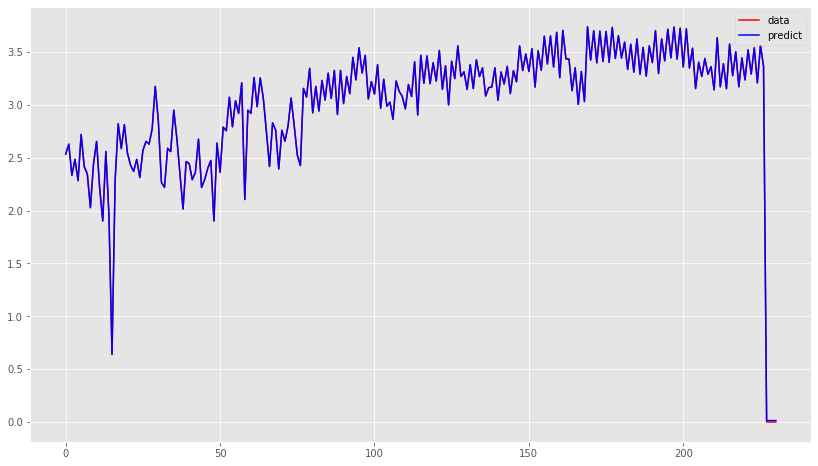

x_scale:  (231, 3, 2)


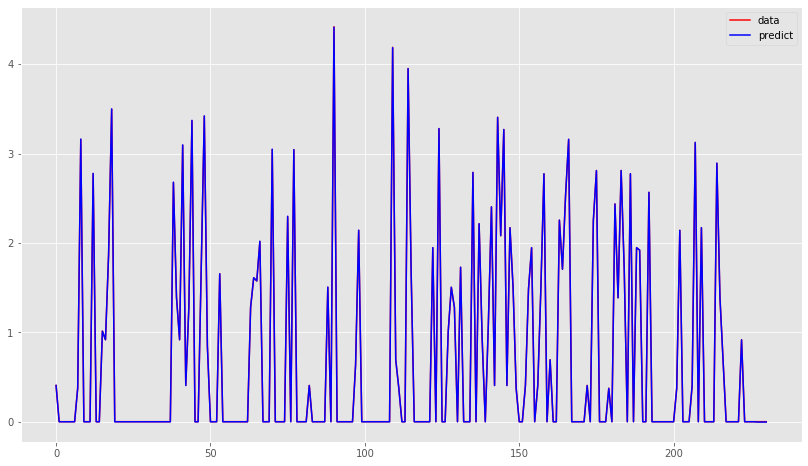

8/8 [==============================] - 0s 3ms/step - loss: 0.0220 - mse: 0.0220
model evaluate mse: [0.02200416848063469, 0.02200416848063469]


In [24]:
model.fit(x, x, epochs=400)
window = time_steps
x_test, scaler = prepare_data(X_test_joint, time_steps, variable_number)
predict_test, x_scale_test = predict_model_show_graph(X_test_day[window + 1:], 
                                                       x_test, scaler, model,
                                                       variable_number)